# Audio MNIST


### Descripción:

En este problema, se presenta un conjunto de datos que contiene clips de audio correspondientes a dígitos
hablados del 0 al 9.

spoken_digit | TensorFlow Datasets

El dataset proporcionado incluye un total de 2500 clips de audio correspondientes a 5 locutores distintos,
50 clips por dígito por locutor.

### Objetivo

Utilizando el dataset proporcionado, el objetivo es construir un modelo de clasificación utilizando redes
neuronales que pueda inferir con precisión el dígito correspondiente dado un clip de audio. Se deben
entrenar y evaluar modelos utilizando técnicas adecuadas de validación y métricas de evaluación de
clasificación.
Se solicita entrenar dos modelos de distintas arquitecturas y comparar los resultados:
- Modelo convolucional sobre los espectrogramas de los clips.
- Modelo recurrente sobre los espectrogramas de los clips.
- Grabar un dataset de test con 10 audios (uno para cada dígito) de cada integrante del grupo y evaluar el modelo sobre el mismo.

CLASIFICACIÓN DE DÍGITOS HABLADOS USANDO DEEP LEARNING

Dataset: Free Spoken Digit Dataset (FSDD)

Objetivo: Clasificar audios de dígitos del 0 al 9

Modelos: CNN y RNN sobre espectrogramas

### 📚 Librerias

In [1]:
# ============================================================================
# IMPORTACIÓN DE LIBRERÍAS
# ============================================================================

# Dataset
import tensorflow_datasets as tfds

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import librosa
import librosa.display
import os
import warnings
warnings.filterwarnings('ignore')

### 🔋Dataset

In [2]:
# ============================================================================
# DESCARGA Y CARGA DEL DATASET
# ============================================================================

print("Cargando dataset...")
ds, info = tfds.load('spoken_digit', split='train', with_info=True, shuffle_files=True)

# Extraer audios y etiquetas
audios = []
labels = []

for example in ds:
    audio = example['audio'].numpy()
    label = example['label'].numpy()
    audios.append(audio)
    labels.append(label)

audios = np.array(audios, dtype=object)
labels = np.array(labels)

print("\nNormalizando audios...")
audios_normalizados = []
for audio in audios:
    audio = audio.astype(np.float32)
    if np.max(np.abs(audio)) > 0:
        audio = audio / np.max(np.abs(audio))  # Normalizar a [-1, 1]
    audios_normalizados.append(audio)

audios = np.array(audios_normalizados, dtype=object)

print(f"\nTotal de muestras: {len(audios)}")
print(f"\nClases: {np.unique(labels)}")
print(f"\nDistribución de clases:")
for i in range(10):
    count = np.sum(labels == i)
    print(f"  Dígito {i}: {count} muestras")

Cargando dataset...

Normalizando audios...

Total de muestras: 2500

Clases: [0 1 2 3 4 5 6 7 8 9]

Distribución de clases:
  Dígito 0: 250 muestras
  Dígito 1: 250 muestras
  Dígito 2: 250 muestras
  Dígito 3: 250 muestras
  Dígito 4: 250 muestras
  Dígito 5: 250 muestras
  Dígito 6: 250 muestras
  Dígito 7: 250 muestras
  Dígito 8: 250 muestras
  Dígito 9: 250 muestras


### 🔎📊 Análisis exploratorio y visualizaciones

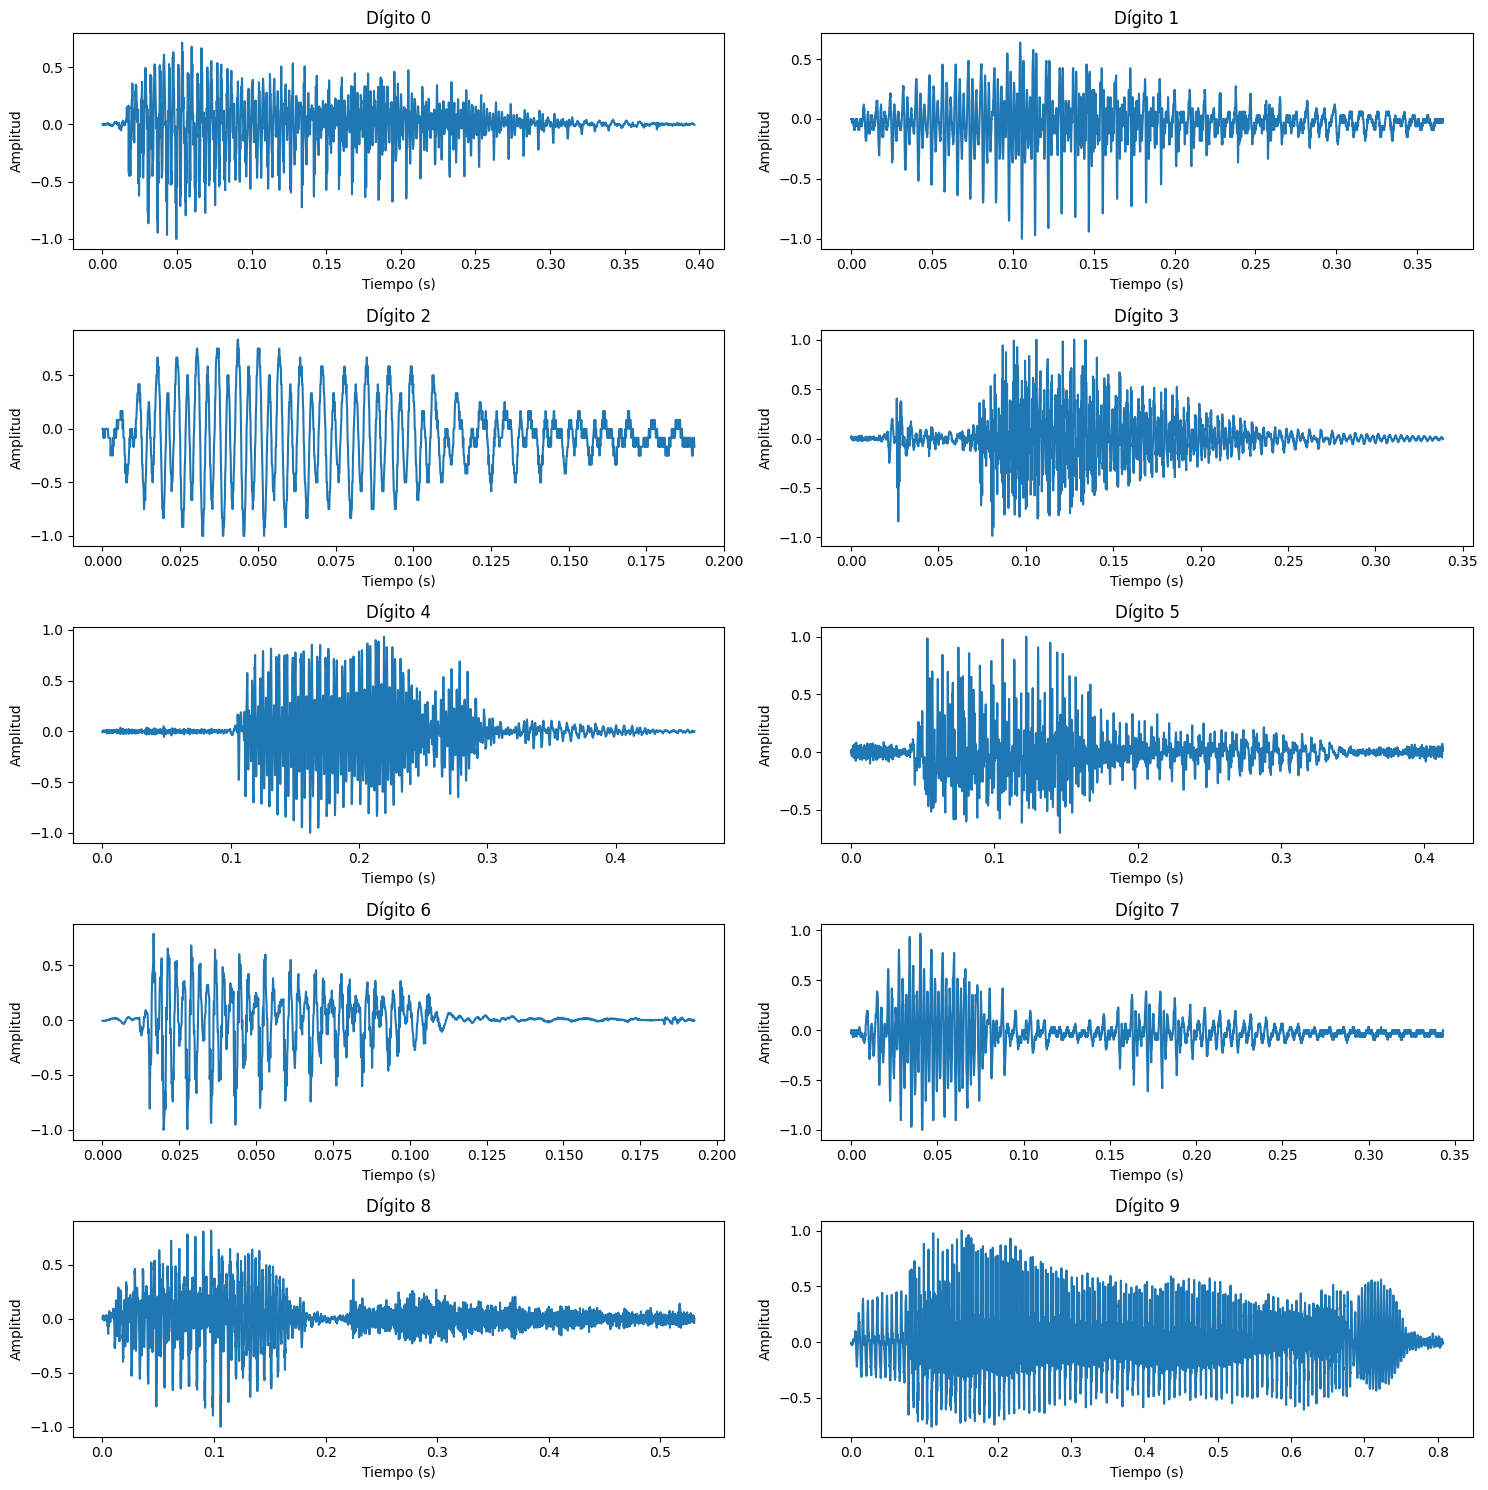

In [3]:
# ============================================================================
# VISUALIZACIÓN DE EJEMPLOS DE AUDIO
# ============================================================================

unique_labels = np.unique(labels)
num_examples = len(unique_labels)
rows = int(np.ceil(num_examples / 2))
cols = min(num_examples, 2)

plt.figure(figsize=(15, rows * 3))


for i, digito in enumerate(unique_labels):
    plt.subplot(rows, cols, i + 1)
    idx = np.where(labels == digito)[0][0]
    audio_signal = audios[idx]
    label = labels[idx]
    tiempo = np.arange(len(audio_signal)) / 8000
    plt.plot(tiempo, audio_signal)
    plt.title(f'Dígito {label}')
    plt.xlabel('Tiempo (s)')
    plt.ylabel('Amplitud')

plt.tight_layout()
plt.show()

In [4]:
# ============================================================================
# EXTRACCIÓN DE CARACTERÍSTICAS: ESPECTROGRAMAS
# ============================================================================

def crear_espectrograma(audio, sample_rate=8000, n_mels=64, duracion_fija=1.0):
    """Convierte audio en mel-espectrograma"""
    
    longitud_objetivo = int(sample_rate * duracion_fija)
    
    if len(audio) < longitud_objetivo:
        audio = np.pad(audio, (0, longitud_objetivo - len(audio)), mode='constant')
    else:
        audio = audio[:longitud_objetivo]
    
    audio = audio.astype(np.float32)
    audio = librosa.effects.preemphasis(audio)
    
    mel_spec = librosa.feature.melspectrogram(
        y=audio, 
        sr=sample_rate,
        n_mels=n_mels,
        n_fft=2048,
        hop_length=512,
        fmin=0,
        fmax=4000
    )
    
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max, top_db=80)
    
    return mel_spec_db

# Crear espectrogramas
print("Creando espectrogramas...")
espectrogramas = []
for i, audio in enumerate(audios):
    if i % 500 == 0:
        print(f"Procesando {i}/{len(audios)}...")
    spec = crear_espectrograma(audio)
    espectrogramas.append(spec)

espectrogramas = np.array(espectrogramas)
print(f"Espectrogramas: {espectrogramas.shape}")

print(f"\nForma de los espectrogramas: {espectrogramas.shape}")
print(f"  - {espectrogramas.shape[0]} muestras")
print(f"  - {espectrogramas.shape[1]} bandas de frecuencia (n_mels)")
print(f"  - {espectrogramas.shape[2]} pasos de tiempo")

Creando espectrogramas...
Procesando 0/2500...
Procesando 500/2500...
Procesando 1000/2500...
Procesando 1500/2500...
Procesando 2000/2500...
Espectrogramas: (2500, 64, 16)

Forma de los espectrogramas: (2500, 64, 16)
  - 2500 muestras
  - 64 bandas de frecuencia (n_mels)
  - 16 pasos de tiempo


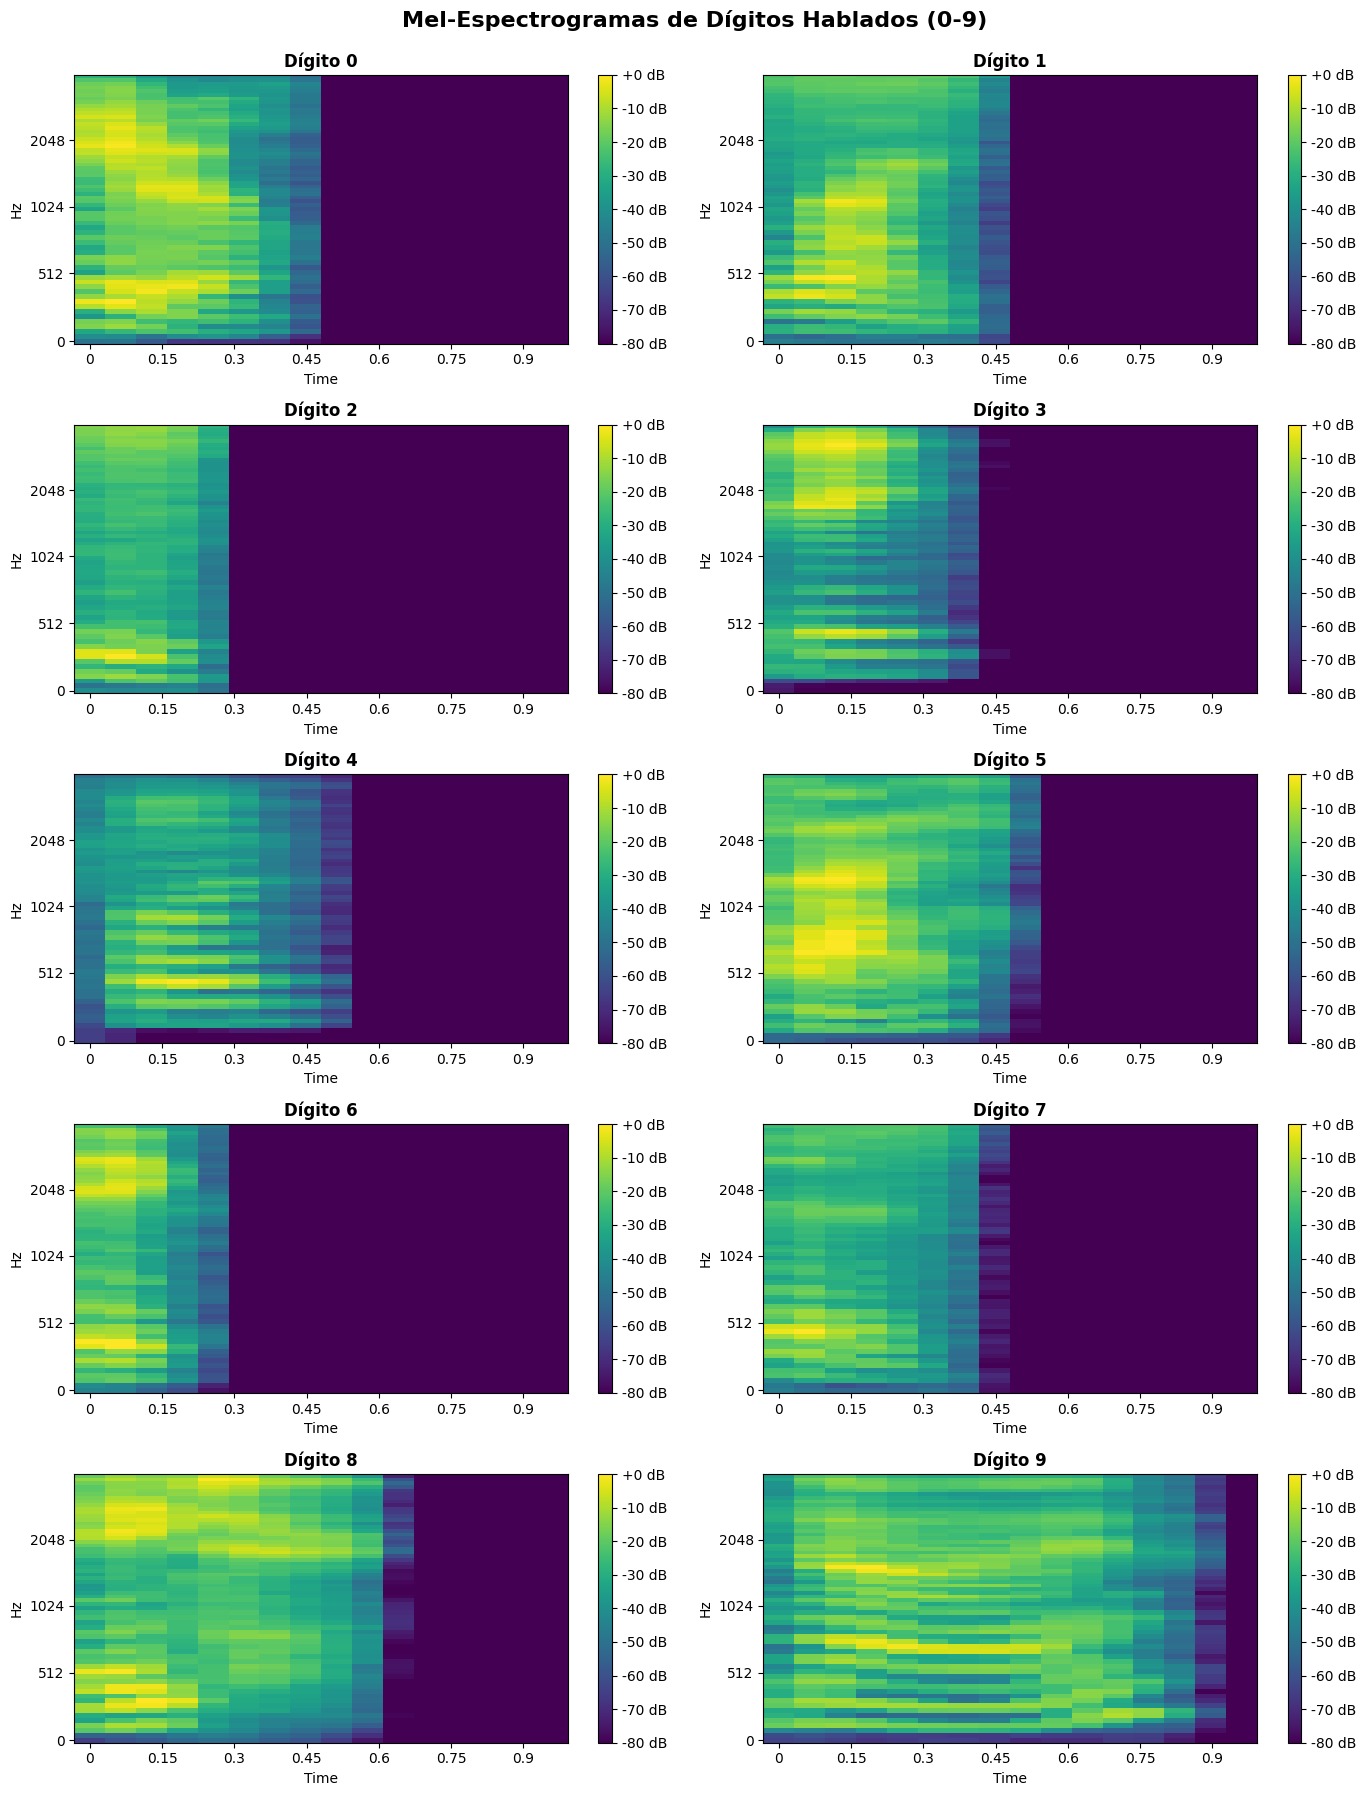

In [5]:
# ============================================================================
# VISUALIZACIÓN DE ESPECTROGRAMAS
# ============================================================================

fig, axes = plt.subplots(5, 2, figsize=(14, 18))
axes = axes.flatten()

for digito in range(10):
    idx = np.where(labels == digito)[0][0]
    img = librosa.display.specshow(
        espectrogramas[idx], 
        sr=8000, 
        hop_length=512,
        x_axis='time', 
        y_axis='mel',
        cmap='viridis',
        ax=axes[digito]
    )
    axes[digito].set_title(f'Dígito {digito}', fontsize=12, fontweight='bold')
    plt.colorbar(img, ax=axes[digito], format='%+2.0f dB')

plt.suptitle('Mel-Espectrogramas de Dígitos Hablados (0-9)', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

In [6]:
# ============================================================================
# PREPARACIÓN DE DATOS
# ============================================================================

X = espectrogramas.copy()

X_min_global = X.min()
X_max_global = X.max()

print(f"\nEstadísticas de normalización:")
print(f"  Min global: {X_min_global:.4f}")
print(f"  Max global: {X_max_global:.4f}")

# Normalizar con estadísticas globales
X = (X - X_min_global) / (X_max_global - X_min_global)
X = X[..., np.newaxis]

y = labels

# Primera división: 70% entrenamiento, 30% temporal
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Segunda división: dividir el 30% en 15% validación y 15% prueba
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"\nEntrenamiento: {X_train.shape[0]} | Validación: {X_val.shape[0]} | Prueba: {X_test.shape[0]}")


Estadísticas de normalización:
  Min global: -80.0000
  Max global: 0.0000

Entrenamiento: 1750 | Validación: 375 | Prueba: 375


### 🌀 Modelo convolucional CNN

In [7]:
def crear_modelo_cnn(input_shape, num_clases=10):
    model = keras.Sequential([

        # Capa de entrada
        layers.Input(shape=input_shape),

        # BLOQUE CONVOLUCIONAL 1
        # Conv2D: Aplica filtros que detectan patrones
        # 64 filtros de 3x3 que se deslizan por el espectrograma
        layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),  # Normaliza activaciones (mejora entrenamiento)
        layers.MaxPooling2D(pool_size=(2, 2)),  # Reduce dimensión a la mitad
        layers.Dropout(0.25),  # Apaga 25% de neuronas (previene overfitting)

        # BLOQUE CONVOLUCIONAL 2
        # Más filtros = más capacidad para detectar patrones complejos
        layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.25),

        # BLOQUE CONVOLUCIONAL 3
        layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.3),

        # CLASIFICADOR
        layers.Flatten(),  # Convierte matriz 2D en vector 1D
        layers.Dense(64, activation='relu'),  # Capa densa (fully connected)
        layers.Dropout(0.4),
        layers.Dense(num_clases, activation='softmax')  # Salida: probabilidad por clase
    ])
    return model

print("\n" + "="*70)
print("MODELO CNN")
print("="*70)

modelo_cnn = crear_modelo_cnn(X_train.shape[1:])
modelo_cnn.summary()

modelo_cnn.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

callbacks_cnn = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7)
]


MODELO CNN


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 16, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 8, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 8, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 8, 64)      │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 8, 64)      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 4, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 4, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 4, 128)     │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 4, 128)     │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       131,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 244,234 (954.04 KB)

 Trainable params: 243,722 (952.04 KB)

 Non-trainable params: 512 (2.00 KB)

In [8]:
# Entrenamiento del modelo
history_cnn = modelo_cnn.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=callbacks_cnn,
    verbose=1
)

Epoch 1/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - accuracy: 0.1371 - loss: 2.4574 - val_accuracy: 0.0987 - val_loss: 4.9963 - learning_rate: 0.0010
Epoch 2/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.2000 - loss: 2.1771 - val_accuracy: 0.0987 - val_loss: 7.5284 - learning_rate: 0.0010
Epoch 3/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.2869 - loss: 1.9713 - val_accuracy: 0.1040 - val_loss: 9.1689 - learning_rate: 0.0010
Epoch 4/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.3434 - loss: 1.7059 - val_accuracy: 0.0987 - val_loss: 12.0800 - learning_rate: 0.0010
Epoch 5/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.4206 - loss: 1.5122 - val_accuracy: 0.0987 - val_loss: 16.6233 - learning_rate: 0.0010
Epoch 6/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.5246 - loss: 1.2834 - val_accuracy: 0.0987 - val_loss: 18.9997 - learning_rate: 0.0010
Epoch 7/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.5777 - loss: 1.1196

In [9]:
# Evaluación CNN
test_loss_cnn, test_acc_cnn = modelo_cnn.evaluate(X_test, y_test, verbose=0)
print(f"\nCNN - Precisión: {test_acc_cnn*100:.2f}%")

y_pred_cnn = modelo_cnn.predict(X_test)
y_pred_cnn_classes = np.argmax(y_pred_cnn, axis=1)

print("\nReporte CNN:")
print(classification_report(y_test, y_pred_cnn_classes, target_names=[str(i) for i in range(10)]))


CNN - Precisión: 99.20%
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

Reporte CNN:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        37
           1       0.97      0.95      0.96        37
           2       1.00      1.00      1.00        38
           3       1.00      1.00      1.00        38
           4       1.00      0.97      0.99        38
           5       0.97      1.00      0.99        37
           6       1.00      1.00      1.00        38
           7       1.00      1.00      1.00        37
           8       1.00      1.00      1.00        37
           9       0.97      1.00      0.99        38

    accuracy                           0.99       375
   macro avg       0.99      0.99      0.99       375
weighted avg       0.99      0.99      0.99       375



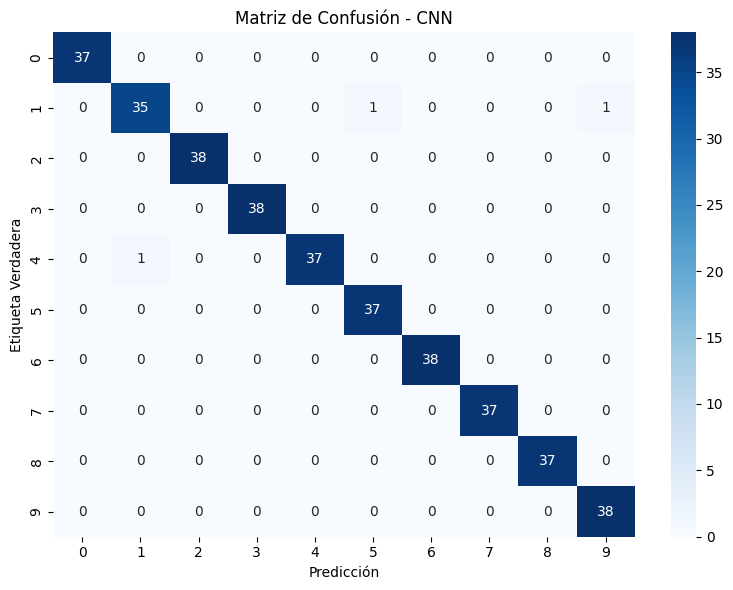

In [10]:
# Matriz de confusión CNN
cm_cnn = confusion_matrix(y_test, y_pred_cnn_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.title('Matriz de Confusión - CNN')
plt.ylabel('Etiqueta Verdadera')
plt.xlabel('Predicción')
plt.tight_layout()
plt.show()

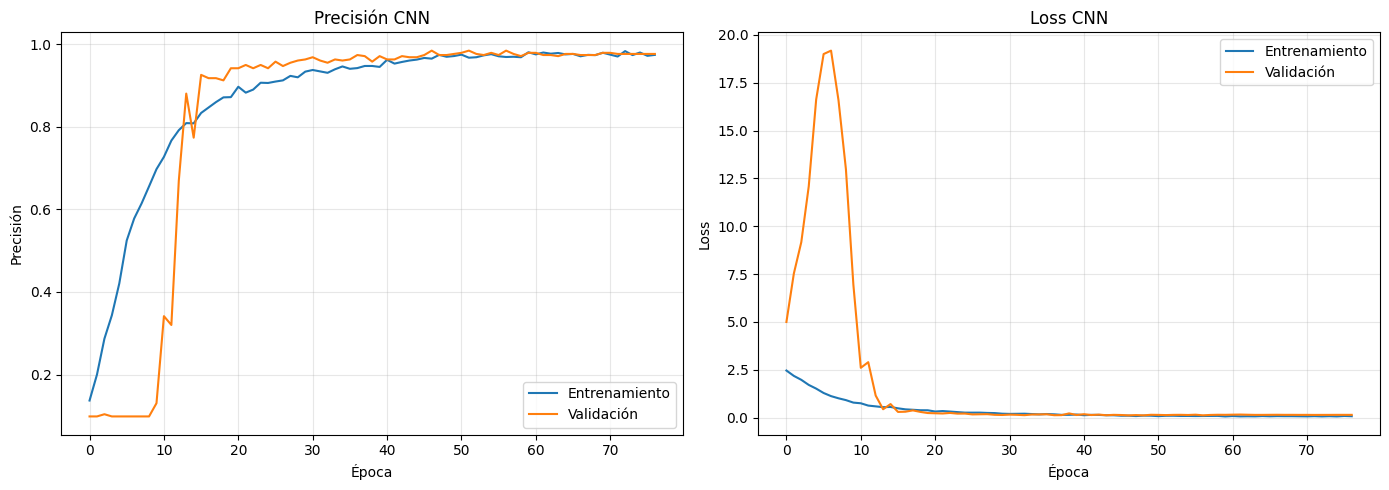

In [11]:
# Gráficas de entrenamiento CNN
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].plot(history_cnn.history['accuracy'], label='Entrenamiento')
axes[0].plot(history_cnn.history['val_accuracy'], label='Validación')
axes[0].set_title('Precisión CNN')
axes[0].set_xlabel('Época')
axes[0].set_ylabel('Precisión')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(history_cnn.history['loss'], label='Entrenamiento')
axes[1].plot(history_cnn.history['val_loss'], label='Validación')
axes[1].set_title('Loss CNN')
axes[1].set_xlabel('Época')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 🧠 Modelo recurrente RNN

In [79]:
X_train_rnn = X_train.squeeze(-1).transpose(0, 2, 1)
X_val_rnn = X_val.squeeze(-1).transpose(0, 2, 1)
X_test_rnn = X_test.squeeze(-1).transpose(0, 2, 1)

def crear_modelo_rnn(input_shape, num_clases=10):
    model = keras.Sequential([
        layers.Input(shape=input_shape),
        
        # Una sola Bidirectional LSTM (más poderosa que 2 LSTMs unidireccionales)
        layers.Bidirectional(layers.LSTM(32, return_sequences=False)),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        
        layers.Dense(64, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        
        layers.Dense(num_clases, activation='softmax')
    ])
    return model

print("\n" + "="*70)
print("MODELO RNN (LSTM)")
print("="*70)

modelo_rnn = crear_modelo_rnn(X_train_rnn.shape[1:])
modelo_rnn.summary()

modelo_rnn.compile(
    optimizer=keras.optimizers.Adam(
        learning_rate=0.0005,
        clipnorm=1.0  # Clip gradients para estabilidad
    ),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
callbacks_rnn = [
    keras.callbacks.EarlyStopping(
        monitor='val_accuracy',  # Monitorear accuracy en vez de loss
        patience=40,
        restore_best_weights=True,
        min_delta=0.001,
        mode='max'  # Maximizar accuracy
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_accuracy',
        factor=0.5,
        patience=10,
        min_lr=1e-7,
        verbose=1,
        mode='max'
    )
]


MODELO RNN (LSTM)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_3 (Bidirectional) │ (None, 64)             │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,154 (117.79 KB)

 Trainable params: 29,898 (116.79 KB)

 Non-trainable params: 256 (1.00 KB)

In [80]:
# Entrenar por más epochs
history_rnn = modelo_rnn.fit(
    X_train_rnn, y_train,
    validation_data=(X_val_rnn, y_val),
    epochs=100,  # Más epochs
    batch_size=64,
    callbacks=callbacks_rnn,
    verbose=1
)

Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.1343 - loss: 3.2113 - val_accuracy: 0.1840 - val_loss: 2.2726 - learning_rate: 5.0000e-04
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2451 - loss: 2.4632 - val_accuracy: 0.1200 - val_loss: 2.2560 - learning_rate: 5.0000e-04
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3291 - loss: 2.0996 - val_accuracy: 0.1013 - val_loss: 2.2453 - learning_rate: 5.0000e-04
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4257 - loss: 1.7502 - val_accuracy: 0.1307 - val_loss: 2.1784 - learning_rate: 5.0000e-04
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4434 - loss: 1.6134 - val_accuracy: 0.1520 - val_loss: 2.1340 - learning_rate: 5.0000e-04
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5217 - loss: 1.4236 - val_accuracy: 0.1867 - val_loss: 2.0599 - learning_rate: 5.0000e-04
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5731

In [81]:
# Evaluación RNN
test_loss_rnn, test_acc_rnn = modelo_rnn.evaluate(X_test_rnn, y_test, verbose=0)
print(f"\nRNN - Precisión: {test_acc_rnn*100:.2f}%")

y_pred_rnn = modelo_rnn.predict(X_test_rnn)
y_pred_rnn_classes = np.argmax(y_pred_rnn, axis=1)

# Reporte con metricas por clase
print("\nReporte RNN:")
print(classification_report(y_test, y_pred_rnn_classes, target_names=[str(i) for i in range(10)]))


RNN - Precisión: 97.33%
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step

Reporte RNN:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97        37
           1       1.00      0.89      0.94        37
           2       0.97      1.00      0.99        38
           3       0.97      1.00      0.99        38
           4       1.00      1.00      1.00        38
           5       0.95      1.00      0.97        37
           6       0.95      0.92      0.93        38
           7       1.00      1.00      1.00        37
           8       0.97      0.95      0.96        37
           9       0.95      1.00      0.97        38

    accuracy                           0.97       375
   macro avg       0.97      0.97      0.97       375
weighted avg       0.97      0.97      0.97       375



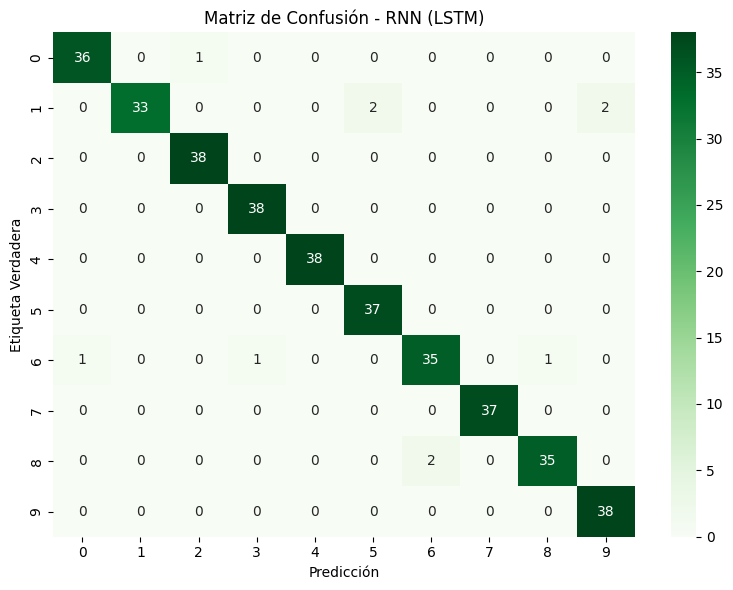

In [82]:
# Matriz de confusión RNN
cm_rnn = confusion_matrix(y_test, y_pred_rnn_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rnn, annot=True, fmt='d', cmap='Greens', xticklabels=range(10), yticklabels=range(10))
plt.title('Matriz de Confusión - RNN (LSTM)')
plt.ylabel('Etiqueta Verdadera')
plt.xlabel('Predicción')
plt.tight_layout()
plt.show()

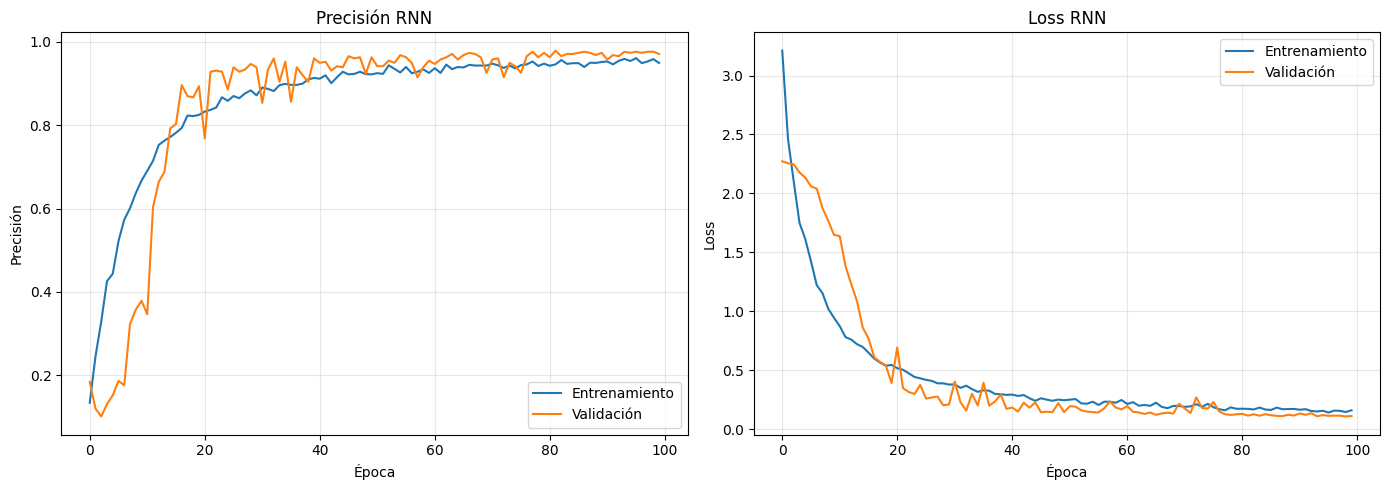

In [83]:
# Gráficas de entrenamiento RNN
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].plot(history_rnn.history['accuracy'], label='Entrenamiento')
axes[0].plot(history_rnn.history['val_accuracy'], label='Validación')
axes[0].set_title('Precisión RNN')
axes[0].set_xlabel('Época')
axes[0].set_ylabel('Precisión')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(history_rnn.history['loss'], label='Entrenamiento')
axes[1].plot(history_rnn.history['val_loss'], label='Validación')
axes[1].set_title('Loss RNN')
axes[1].set_xlabel('Época')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 🧬 Modelo hibrido CNN+RNN

In [ ]:

def crear_modelo_hibrido(input_shape, num_clases=10):
    """
    Modelo híbrido: CNN extrae características + RNN captura temporal
    """
    model = keras.Sequential([
        layers.Input(shape=input_shape),
        
        # BLOQUE CNN (extrae características espaciales del espectrograma)
        layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 1)),  # Pool solo en frecuencia
        layers.Dropout(0.25),
        
        layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 1)),
        layers.Dropout(0.25),
        
        # Reshape para RNN: convertir (batch, freq, time, channels) → (batch, time, features)
        layers.Permute((2, 1, 3)),  # (time, freq, channels)
        layers.Reshape((-1, input_shape[0] // 4 * 64)),  # (time, freq*channels)
        
        # BLOQUE RNN (captura patrones temporales)
        layers.LSTM(64, return_sequences=False),
        layers.BatchNormalization(),
        layers.Dropout(0.25),
        
        # CLASIFICADOR
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_clases, activation='softmax')
    ])
    return model

print("\n" + "="*70)
print("MODELO CNN-RNN HÍBRIDO")
print("="*70)

# Crear modelo (usa los MISMOS datos que CNN, NO los de RNN)
modelo_hibrido = crear_modelo_hibrido(X_train.shape[1:])
modelo_hibrido.summary()

# Compilar
modelo_hibrido.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
callbacks_hibrido = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss', 
        patience=30, 
        restore_best_weights=True
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.5, 
        patience=8, 
        min_lr=1e-7,
        verbose=1
    )
]


MODELO CNN-RNN HÍBRIDO


Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_27 (Conv2D)              │ (None, 64, 16, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_48          │ (None, 64, 16, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 32, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_62 (Dropout)            │ (None, 32, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 32, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_49          │ (None, 32, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_63 (Dropout)            │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ permute_13 (Permute)            │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_13 (Reshape)            │ (None, 16, 1024)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_17 (LSTM)                  │ (None, 64)             │       278,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_50          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_64 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_65 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 303,050 (1.16 MB)

 Trainable params: 302,730 (1.15 MB)

 Non-trainable params: 320 (1.25 KB)

In [220]:
# Entrenar
print("\nEntrenando modelo híbrido...")
history_hibrido = modelo_hibrido.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=64,
    callbacks=callbacks_hibrido,
    verbose=1
)


Entrenando modelo híbrido...
Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.1103 - loss: 2.8481 - val_accuracy: 0.0987 - val_loss: 2.3158 - learning_rate: 0.0010
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.1109 - loss: 2.4988 - val_accuracy: 0.0987 - val_loss: 2.4428 - learning_rate: 0.0010
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.1400 - loss: 2.3369 - val_accuracy: 0.0987 - val_loss: 2.7107 - learning_rate: 0.0010
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.1977 - loss: 2.1999 - val_accuracy: 0.0987 - val_loss: 2.9172 - learning_rate: 0.0010
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.2491 - loss: 2.0596 - val_accuracy: 0.0987 - val_loss: 3.1661 - learning_rate: 0.0010
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.3160 - loss: 1.9044 - val_accuracy: 0.0987 - val_loss: 3.4722 - learning_rate: 0.0010
Epoch 7/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0

In [221]:
# Evaluación
test_loss_hibrido, test_acc_hibrido = modelo_hibrido.evaluate(X_test, y_test, verbose=0)
print(f"\nHíbrido - Precisión: {test_acc_hibrido*100:.2f}%")

y_pred_hibrido = modelo_hibrido.predict(X_test)
y_pred_hibrido_classes = np.argmax(y_pred_hibrido, axis=1)

print("\nReporte Híbrido:")
print(classification_report(y_test, y_pred_hibrido_classes, target_names=[str(i) for i in range(10)]))


Híbrido - Precisión: 98.67%
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

Reporte Híbrido:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        37
           1       1.00      1.00      1.00        37
           2       1.00      1.00      1.00        38
           3       0.95      0.97      0.96        38
           4       1.00      1.00      1.00        38
           5       1.00      1.00      1.00        37
           6       0.97      0.97      0.97        38
           7       1.00      0.97      0.99        37
           8       1.00      0.95      0.97        37
           9       0.95      1.00      0.97        38

    accuracy                           0.99       375
   macro avg       0.99      0.99      0.99       375
weighted avg       0.99      0.99      0.99       375



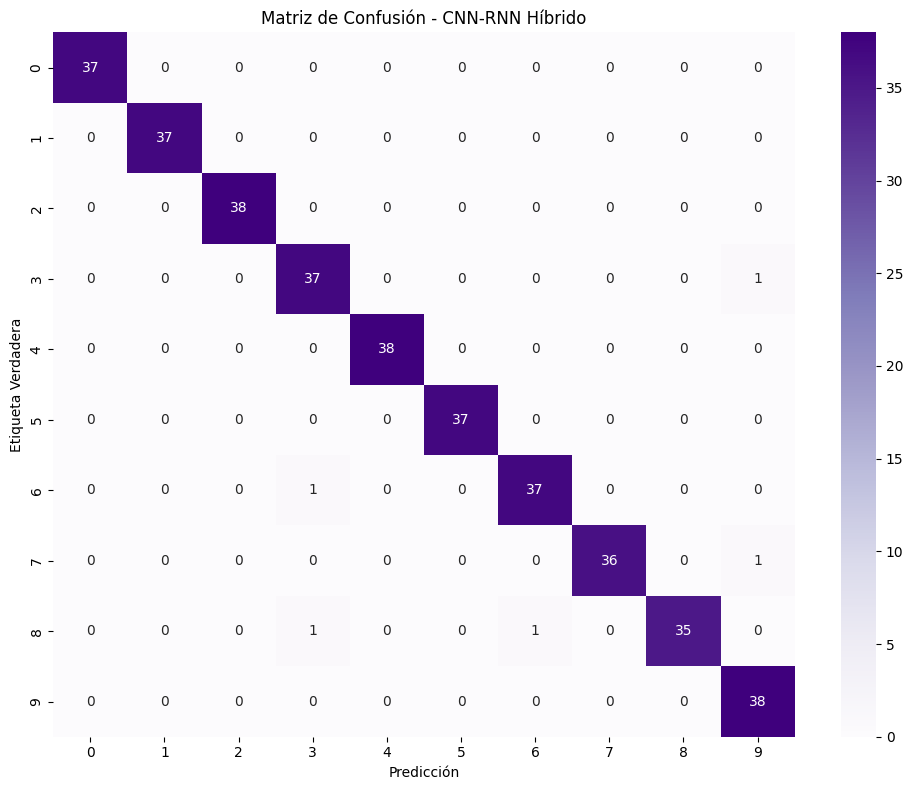

In [222]:
# Matriz de confusión
cm_hibrido = confusion_matrix(y_test, y_pred_hibrido_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_hibrido, annot=True, fmt='d', cmap='Purples', xticklabels=range(10), yticklabels=range(10))
plt.title('Matriz de Confusión - CNN-RNN Híbrido')
plt.ylabel('Etiqueta Verdadera')
plt.xlabel('Predicción')
plt.tight_layout()
plt.show()

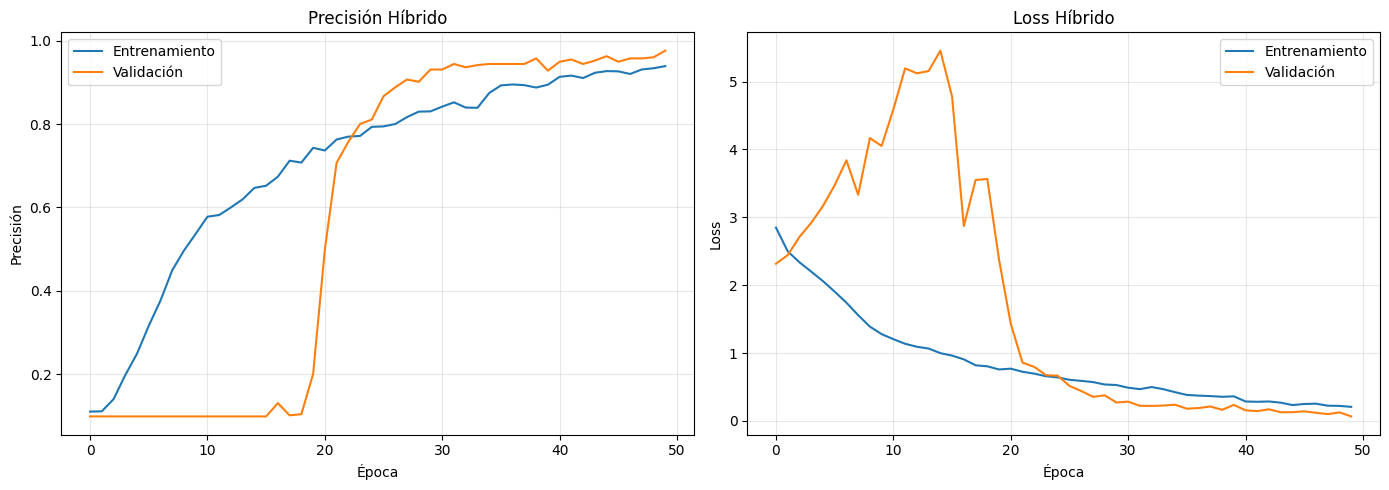

In [223]:
# Gráficas de entrenamiento
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].plot(history_hibrido.history['accuracy'], label='Entrenamiento')
axes[0].plot(history_hibrido.history['val_accuracy'], label='Validación')
axes[0].set_title('Precisión Híbrido')
axes[0].set_xlabel('Época')
axes[0].set_ylabel('Precisión')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(history_hibrido.history['loss'], label='Entrenamiento')
axes[1].plot(history_hibrido.history['val_loss'], label='Validación')
axes[1].set_title('Loss Híbrido')
axes[1].set_xlabel('Época')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### ⚖️ Comparación todos los modelos

In [224]:
# ============================================================================
# COMPARACIÓN DE MODELOS
# ============================================================================

print("\n" + "="*70)
print("COMPARACIÓN FINAL DE LOS 3 MODELOS")
print("="*70)

resultados = pd.DataFrame({
    'Modelo': ['CNN', 'RNN (LSTM)', 'CNN-RNN Híbrido'],
    'Precisión Test (%)': [test_acc_cnn * 100, test_acc_rnn * 100, test_acc_hibrido * 100],
    'Loss Test': [test_loss_cnn, test_loss_rnn, test_loss_hibrido],
    'Parámetros': [modelo_cnn.count_params(), modelo_rnn.count_params(), modelo_hibrido.count_params()]
})

print("\n", resultados.to_string(index=False))


COMPARACIÓN FINAL DE LOS 3 MODELOS

          Modelo  Precisión Test (%)  Loss Test  Parámetros
            CNN           99.199998   0.031883      244234
     RNN (LSTM)           97.333336   0.071041       30154
CNN-RNN Híbrido           98.666668   0.053898      303050


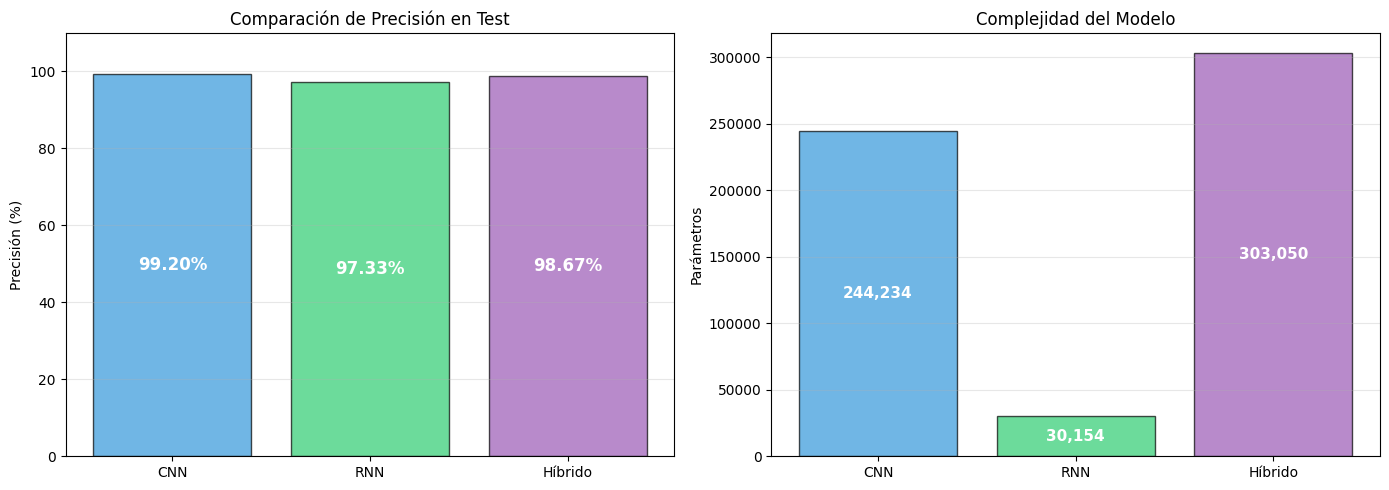

In [225]:
# Gráficas comparativas
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

modelos = ['CNN', 'RNN', 'Híbrido']
precisiones = [test_acc_cnn * 100, test_acc_rnn * 100, test_acc_hibrido * 100]
colores = ['#3498db', '#2ecc71', '#9b59b6']

axes[0].bar(modelos, precisiones, color=colores, alpha=0.7, edgecolor='black')
axes[0].set_ylabel('Precisión (%)')
axes[0].set_title('Comparación de Precisión en Test')
axes[0].set_ylim([0, 110])
axes[0].grid(True, alpha=0.3, axis='y')

for i, v in enumerate(precisiones):
    axes[0].text(i, v / 2, f'{v:.2f}%', ha='center', va='center', 
                 fontweight='bold', fontsize=12, color='white')

parametros = [modelo_cnn.count_params(), modelo_rnn.count_params(), modelo_hibrido.count_params()]
axes[1].bar(modelos, parametros, color=colores, alpha=0.7, edgecolor='black')
axes[1].set_ylabel('Parámetros')
axes[1].set_title('Complejidad del Modelo')
axes[1].grid(True, alpha=0.3, axis='y')

for i, v in enumerate(parametros):
    axes[1].text(i, v / 2, f'{v:,}', ha='center', va='center', 
                 fontweight='bold', fontsize=11, color='white')

plt.tight_layout()
plt.show()

In [246]:
# ============================================================================
# EJEMPLOS DE PREDICCIÓN
# ============================================================================

print("\n" + "="*70)
print("EJEMPLOS DE PREDICCIÓN")
print("="*70)

num_ejemplos = 5
indices_aleatorios = np.random.choice(len(X_test), num_ejemplos, replace=False)

for idx in indices_aleatorios:
    pred_cnn = modelo_cnn.predict(X_test[idx:idx+1], verbose=0)
    pred_rnn = modelo_rnn.predict(X_test_rnn[idx:idx+1], verbose=0)
    pred_hibrido = modelo_hibrido.predict(X_test[idx:idx+1], verbose=0)
    
    clase_cnn = np.argmax(pred_cnn)
    clase_rnn = np.argmax(pred_rnn)
    clase_hibrido = np.argmax(pred_hibrido)
    clase_real = y_test[idx]
    
    confianza_cnn = pred_cnn[0][clase_cnn] * 100
    confianza_rnn = pred_rnn[0][clase_rnn] * 100
    confianza_hibrido = pred_hibrido[0][clase_hibrido] * 100
    
    print(f"\nEjemplo {idx}: Real={clase_real} | CNN={clase_cnn} ({confianza_cnn:.1f}%) | RNN={clase_rnn} ({confianza_rnn:.1f}%) | Híbrido={clase_hibrido} ({confianza_hibrido:.1f}%)")



EJEMPLOS DE PREDICCIÓN

Ejemplo 200: Real=6 | CNN=6 (100.0%) | RNN=8 (62.4%) | Híbrido=6 (99.9%)

Ejemplo 245: Real=7 | CNN=7 (100.0%) | RNN=7 (100.0%) | Híbrido=7 (99.9%)

Ejemplo 143: Real=1 | CNN=1 (100.0%) | RNN=1 (99.9%) | Híbrido=1 (99.8%)

Ejemplo 16: Real=7 | CNN=7 (100.0%) | RNN=7 (99.6%) | Híbrido=7 (99.6%)

Ejemplo 59: Real=5 | CNN=5 (100.0%) | RNN=5 (98.2%) | Híbrido=5 (97.5%)


### 🎙 Carga del dataset personalizado

In [ ]:
# ============================================================================
# FUNCIONES PARA LA EVALUACIÓN CON DATASET PERSONALIZADO
# ============================================================================

def cargar_audio_personalizado(ruta_archivo, duracion_objetivo=1.0, sample_rate_objetivo=8000):
    try:
        audio, sr = librosa.load(ruta_archivo, sr=sample_rate_objetivo, duration=duracion_objetivo)
        
        if np.max(np.abs(audio)) > 0:
            audio = audio / np.max(np.abs(audio))
        
        longitud_objetivo = int(sample_rate_objetivo * duracion_objetivo)
        
        if len(audio) < longitud_objetivo:
            audio = np.pad(audio, (0, longitud_objetivo - len(audio)), mode='constant')
        else:
            audio = audio[:longitud_objetivo]
        
        return audio, sr
    except Exception as e:
        print(f"Error: {e}")
        return None, None

def evaluar_dataset_personalizado(ruta_carpeta_principal, modelo_cnn, modelo_rnn, modelo_hibrido):
    resultados = []
    
    if not os.path.exists(ruta_carpeta_principal):
        print(f"⚠️  '{ruta_carpeta_principal}' no existe")
        return None
    
    integrantes = [d for d in os.listdir(ruta_carpeta_principal) 
                   if os.path.isdir(os.path.join(ruta_carpeta_principal, d))]
    
    if len(integrantes) == 0:
        print("⚠️  No hay carpetas de integrantes")
        return None
    
    print(f"\n📁 Integrantes: {integrantes}")
    
    for integrante in integrantes:
        carpeta_integrante = os.path.join(ruta_carpeta_principal, integrante)
        print(f"\n👤 {integrante}")
        
        for digito in range(10):
            posibles_extensiones = ['.wav', '.mp3', '.m4a', '.ogg']
            archivo_encontrado = None
            
            for ext in posibles_extensiones:
                ruta_posible = os.path.join(carpeta_integrante, f"{digito}{ext}")
                if os.path.exists(ruta_posible):
                    archivo_encontrado = ruta_posible
                    break
            
            if archivo_encontrado is None:
                print(f"  ⚠️  Dígito {digito}: No encontrado")
                continue
            
            audio, sr = cargar_audio_personalizado(archivo_encontrado)
            
            if audio is None:
                continue
            
            espectrograma = crear_espectrograma(audio, sample_rate=sr)
            spec_norm = (espectrograma - espectrogramas.min()) / (espectrogramas.max() - espectrogramas.min())
            spec_norm = np.clip(spec_norm, 0, 1)
            
            X_cnn = spec_norm[np.newaxis, ..., np.newaxis]
            X_rnn = spec_norm.T[np.newaxis, ...]
            
            # Predicciones con todos los modelos
            pred_cnn = modelo_cnn.predict(X_cnn, verbose=0)
            pred_rnn = modelo_rnn.predict(X_rnn, verbose=0)
            pred_hibrido = modelo_hibrido.predict(X_cnn, verbose=0)  # Usa misma forma que CNN
            
            clase_pred_cnn = np.argmax(pred_cnn)
            clase_pred_rnn = np.argmax(pred_rnn)
            clase_pred_hibrido = np.argmax(pred_hibrido)
            
            confianza_cnn = pred_cnn[0][clase_pred_cnn] * 100
            confianza_rnn = pred_rnn[0][clase_pred_rnn] * 100
            confianza_hibrido = pred_hibrido[0][clase_pred_hibrido] * 100
            
            acierto_cnn = "✓" if clase_pred_cnn == digito else "✗"
            acierto_rnn = "✓" if clase_pred_rnn == digito else "✗"
            acierto_hibrido = "✓" if clase_pred_hibrido == digito else "✗"
            
            resultados.append({
                'Integrante': integrante,
                'Dígito_Real': digito,
                'Pred_CNN': clase_pred_cnn,
                'Conf_CNN_%': round(confianza_cnn, 2),
                'Acierto_CNN': acierto_cnn,
                'Pred_RNN': clase_pred_rnn,
                'Conf_RNN_%': round(confianza_rnn, 2),
                'Acierto_RNN': acierto_rnn,
                'Pred_Híbrido': clase_pred_hibrido,
                'Conf_Híbrido_%': round(confianza_hibrido, 2),
                'Acierto_Híbrido': acierto_hibrido
            })
            
            print(f"  {digito}: CNN→{clase_pred_cnn}{acierto_cnn} | RNN→{clase_pred_rnn}{acierto_rnn} | Híbrido→{clase_pred_hibrido}{acierto_hibrido}")    

    if len(resultados) == 0:
        print("\n⚠️  No se procesaron audios")
        return None
    
    return pd.DataFrame(resultados)

### 👥 Evaluación de audios personalizados

In [ ]:
# ============================================================================
# OBTENER PREDICCIONES
# ============================================================================

print("\n" + "="*70)
print("EVALUACIÓN CON DATASET PERSONALIZADO")
print("="*70)

RUTA_AUDIO_GRUPO = 'audio_grupo'

df_resultados_grupo = evaluar_dataset_personalizado(RUTA_AUDIO_GRUPO, modelo_cnn, modelo_rnn, modelo_hibrido)

# ============================================================================
# MOSTRAR RESULTADOS DETALLADOS
# ============================================================================

print("\n" + "="*70)
print("TABLA DE RESULTADOS DETALLADOS")
print("="*70)
print(df_resultados_grupo.to_string(index=False))

# ============================================================================
# CALCULAR MÉTRICAS
# ============================================================================

print("\n" + "="*70)
print("MÉTRICAS GENERALES")
print("="*70)

total_muestras = len(df_resultados_grupo)
aciertos_cnn = (df_resultados_grupo['Acierto_CNN'] == '✓').sum()
aciertos_rnn = (df_resultados_grupo['Acierto_RNN'] == '✓').sum()
aciertos_hibrido = (df_resultados_grupo['Acierto_Híbrido'] == '✓').sum()

acc_cnn_grupo = (aciertos_cnn / total_muestras) * 100
acc_rnn_grupo = (aciertos_rnn / total_muestras) * 100
acc_hibrido_grupo = (aciertos_hibrido / total_muestras) * 100


print(f"\nTotal de muestras: {total_muestras}")
print(f"\nCNN:")
print(f"  Aciertos: {aciertos_cnn}/{total_muestras}")
print(f"  Accuracy: {acc_cnn_grupo:.2f}%")
print(f"\nRNN:")
print(f"  Aciertos: {aciertos_rnn}/{total_muestras}")
print(f"  Accuracy: {acc_rnn_grupo:.2f}%")
print(f"\nHíbrido:")
print(f"  Aciertos: {aciertos_hibrido}/{total_muestras}")
print(f"  Accuracy: {acc_hibrido_grupo:.2f}%")

# ============================================================================
# EVALUACIÓN COMPLETA - ANÁLISIS DE ERRORES
# ============================================================================

print("\n" + "="*70)
print("ANÁLISIS DE ERRORES")
print("="*70)

errores_cnn = df_resultados_grupo[df_resultados_grupo['Acierto_CNN'] == '✗']
errores_rnn = df_resultados_grupo[df_resultados_grupo['Acierto_RNN'] == '✗']
errores_hibrido = df_resultados_grupo[df_resultados_grupo['Acierto_Híbrido'] == '✗']

if len(errores_cnn) > 0:
    print("\n🔴 Errores CNN:")
    for _, error in errores_cnn.iterrows():
        print(f"  {error['Integrante']}: Dígito {error['Dígito_Real']} → Predijo {error['Pred_CNN']} (confianza: {error['Conf_CNN_%']:.1f}%)")
else:
    print("\n✅ CNN: 100% accuracy - Sin errores")

if len(errores_rnn) > 0:
    print("\n🔴 Errores RNN:")
    for _, error in errores_rnn.iterrows():
        print(f"  {error['Integrante']}: Dígito {error['Dígito_Real']} → Predijo {error['Pred_RNN']} (confianza: {error['Conf_RNN_%']:.1f}%)")
else:
    print("\n✅ RNN: 100% accuracy - Sin errores")

if len(errores_hibrido) > 0:
    print("\n🔴 Errores Híbrido:")
    for _, error in errores_hibrido.iterrows():
        print(f"  {error['Integrante']}: Dígito {error['Dígito_Real']} → Predijo {error['Pred_RNN']} (confianza: {error['Conf_RNN_%']:.1f}%)")
else:
    print("\n✅ HIB: 100% accuracy - Sin errores")



EVALUACIÓN CON DATASET PERSONALIZADO

📁 Integrantes: ['fabricio', 'maria']

👤 fabricio
  0: CNN→0✓ | RNN→0✓ | Híbrido→0✓
  1: CNN→1✓ | RNN→1✓ | Híbrido→2✗
  2: CNN→2✓ | RNN→2✓ | Híbrido→2✓
  3: CNN→3✓ | RNN→3✓ | Híbrido→3✓
  4: CNN→4✓ | RNN→4✓ | Híbrido→4✓
  5: CNN→5✓ | RNN→5✓ | Híbrido→5✓
  6: CNN→6✓ | RNN→6✓ | Híbrido→6✓
  7: CNN→7✓ | RNN→7✓ | Híbrido→7✓
  8: CNN→8✓ | RNN→8✓ | Híbrido→8✓
  9: CNN→9✓ | RNN→9✓ | Híbrido→9✓

👤 maria
  0: CNN→0✓ | RNN→0✓ | Híbrido→0✓
  1: CNN→1✓ | RNN→1✓ | Híbrido→1✓
  2: CNN→6✗ | RNN→7✗ | Híbrido→4✗
  3: CNN→3✓ | RNN→3✓ | Híbrido→3✓
  4: CNN→4✓ | RNN→4✓ | Híbrido→4✓
  5: CNN→5✓ | RNN→5✓ | Híbrido→5✓
  6: CNN→6✓ | RNN→6✓ | Híbrido→6✓
  7: CNN→7✓ | RNN→7✓ | Híbrido→7✓
  8: CNN→8✓ | RNN→8✓ | Híbrido→8✓
  9: CNN→9✓ | RNN→9✓ | Híbrido→9✓

TABLA DE RESULTADOS DETALLADOS
Integrante  Dígito_Real  Pred_CNN  Conf_CNN_% Acierto_CNN  Pred_RNN  Conf_RNN_% Acierto_RNN  Pred_Híbrido  Conf_Híbrido_% Acierto_Híbrido
  fabricio            0         0  100.000000        

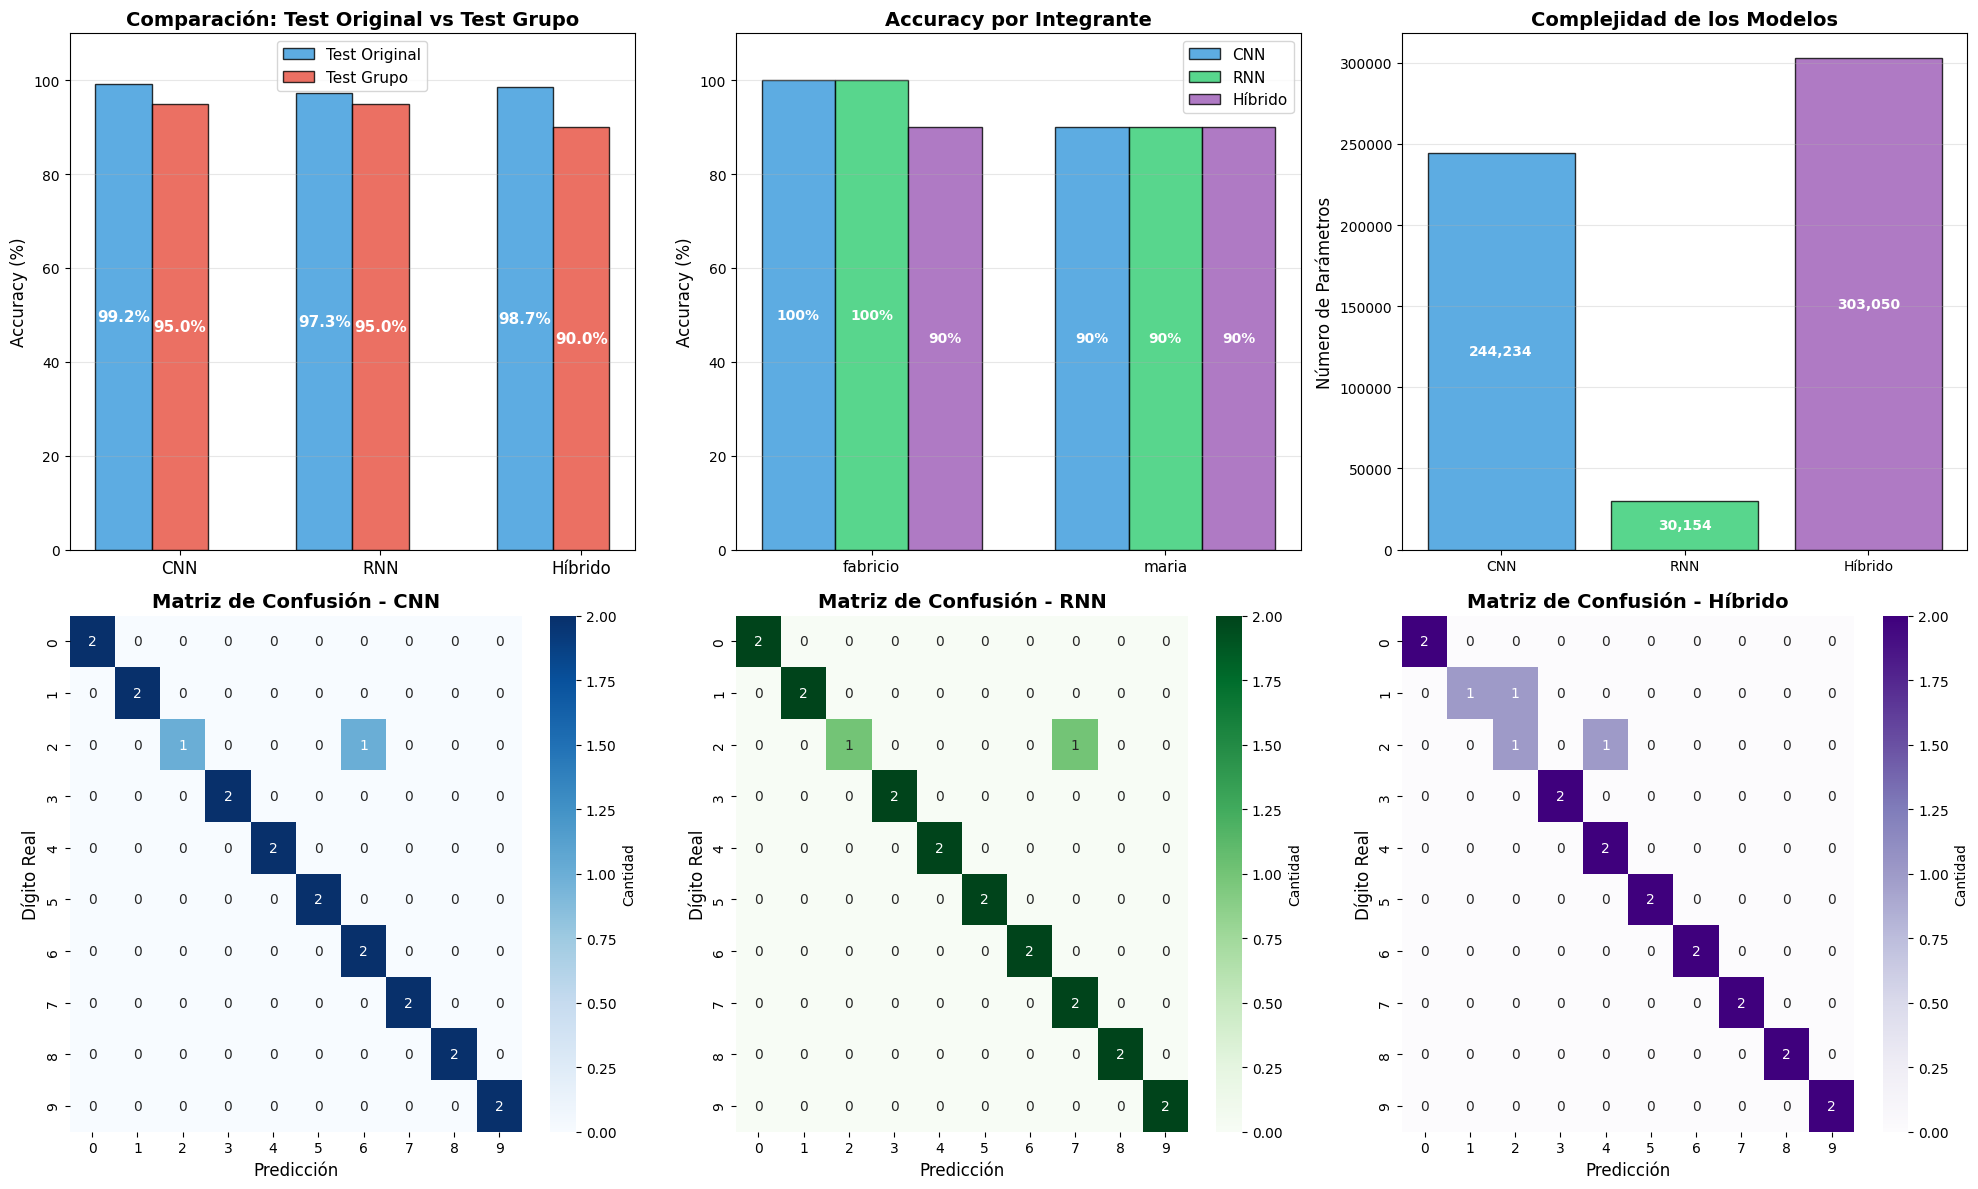

Imagen guardada como 'Comparación modelos.png' en el directorio actual.


In [243]:
# ============================================================================
# Gráficos de Barras y Matrices de Confusión
# ============================================================================
fig, axes = plt.subplots(2, 3, figsize=(20, 12))  # Cambio a 2x3 para 3 matrices

# ============================================================================
# GRÁFICA 1: Comparación Test Original vs Grupo (3 modelos)
# ============================================================================

x = np.arange(3)
width = 0.28

axes[0, 0].bar(x - width, [test_acc_cnn * 100, test_acc_rnn * 100, test_acc_hibrido * 100], 
            width, label='Test Original', color='#3498db', alpha=0.8, edgecolor='black')
axes[0, 0].bar(x, [acc_cnn_grupo, acc_rnn_grupo, acc_hibrido_grupo], 
            width, label='Test Grupo', color='#e74c3c', alpha=0.8, edgecolor='black')

axes[0, 0].set_ylabel('Accuracy (%)', fontsize=12)
axes[0, 0].set_title('Comparación: Test Original vs Test Grupo', fontsize=14, fontweight='bold')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(['CNN', 'RNN', 'Híbrido'], fontsize=12)
axes[0, 0].legend(fontsize=11)
axes[0, 0].set_ylim([0, 110])
axes[0, 0].grid(True, alpha=0.3, axis='y')

# Valores dentro de las barras
for i in range(3):
    valor_orig = [test_acc_cnn * 100, test_acc_rnn * 100, test_acc_hibrido * 100][i]
    axes[0, 0].text(i - width, valor_orig / 2, f'{valor_orig:.1f}%', 
                    ha='center', va='center', fontsize=11, fontweight='bold', color='white')
    valor_grupo = [acc_cnn_grupo, acc_rnn_grupo, acc_hibrido_grupo][i]
    axes[0, 0].text(i, valor_grupo / 2, f'{valor_grupo:.1f}%', 
                    ha='center', va='center', fontsize=11, fontweight='bold', color='white')

# ============================================================================
# GRÁFICA 2: Accuracy por Integrante (3 modelos)
# ============================================================================

integrantes_list = df_resultados_grupo['Integrante'].unique()
acc_cnn_por_int = []
acc_rnn_por_int = []
acc_hibrido_por_int = []

for integrante in integrantes_list:
    df_int = df_resultados_grupo[df_resultados_grupo['Integrante'] == integrante]
    acc_cnn_por_int.append((df_int['Acierto_CNN'] == '✓').sum() / len(df_int) * 100)
    acc_rnn_por_int.append((df_int['Acierto_RNN'] == '✓').sum() / len(df_int) * 100)
    acc_hibrido_por_int.append((df_int['Acierto_Híbrido'] == '✓').sum() / len(df_int) * 100)

x_int = np.arange(len(integrantes_list))
width_int = 0.25

axes[0, 1].bar(x_int - width_int, acc_cnn_por_int, width_int, 
                label='CNN', color='#3498db', alpha=0.8, edgecolor='black')
axes[0, 1].bar(x_int, acc_rnn_por_int, width_int, 
                label='RNN', color='#2ecc71', alpha=0.8, edgecolor='black')
axes[0, 1].bar(x_int + width_int, acc_hibrido_por_int, width_int, 
                label='Híbrido', color='#9b59b6', alpha=0.8, edgecolor='black')

axes[0, 1].set_ylabel('Accuracy (%)', fontsize=12)
axes[0, 1].set_title('Accuracy por Integrante', fontsize=14, fontweight='bold')
axes[0, 1].set_xticks(x_int)
axes[0, 1].set_xticklabels(integrantes_list, fontsize=11, ha='center')
axes[0, 1].legend(fontsize=11)
axes[0, 1].set_ylim([0, 110])
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Valores dentro de las barras
for i in range(len(integrantes_list)):
    axes[0, 1].text(i - width_int, acc_cnn_por_int[i] / 2, 
                    f'{acc_cnn_por_int[i]:.0f}%', ha='center', va='center', 
                    fontsize=10, fontweight='bold', color='white')
    axes[0, 1].text(i, acc_rnn_por_int[i] / 2, 
                    f'{acc_rnn_por_int[i]:.0f}%', ha='center', va='center', 
                    fontsize=10, fontweight='bold', color='white')
    axes[0, 1].text(i + width_int, acc_hibrido_por_int[i] / 2, 
                    f'{acc_hibrido_por_int[i]:.0f}%', ha='center', va='center', 
                    fontsize=10, fontweight='bold', color='white')

# ============================================================================
# GRÁFICA 3: Comparación de Parámetros
# ============================================================================

modelos_nombres = ['CNN', 'RNN', 'Híbrido']
parametros = [modelo_cnn.count_params(), modelo_rnn.count_params(), modelo_hibrido.count_params()]
colores_params = ['#3498db', '#2ecc71', '#9b59b6']

axes[0, 2].bar(modelos_nombres, parametros, color=colores_params, alpha=0.8, edgecolor='black')
axes[0, 2].set_ylabel('Número de Parámetros', fontsize=12)
axes[0, 2].set_title('Complejidad de los Modelos', fontsize=14, fontweight='bold')
axes[0, 2].grid(True, alpha=0.3, axis='y')

# Valores dentro de las barras
for i, v in enumerate(parametros):
    axes[0, 2].text(i, v / 2, f'{v:,}', ha='center', va='center', 
                    fontsize=10, fontweight='bold', color='white')

# ============================================================================
# MATRICES DE CONFUSIÓN
# ============================================================================

y_true_grupo = df_resultados_grupo['Dígito_Real'].values
y_pred_cnn_grupo = df_resultados_grupo['Pred_CNN'].values
y_pred_rnn_grupo = df_resultados_grupo['Pred_RNN'].values
y_pred_hibrido_grupo = df_resultados_grupo['Pred_Híbrido'].values

# Matriz CNN
cm_grupo_cnn = confusion_matrix(y_true_grupo, y_pred_cnn_grupo, labels=range(10))
sns.heatmap(cm_grupo_cnn, annot=True, fmt='d', cmap='Blues', 
            xticklabels=range(10), yticklabels=range(10), 
            ax=axes[1, 0], cbar_kws={'label': 'Cantidad'})
axes[1, 0].set_title('Matriz de Confusión - CNN', fontsize=14, fontweight='bold')
axes[1, 0].set_ylabel('Dígito Real', fontsize=12)
axes[1, 0].set_xlabel('Predicción', fontsize=12)

# Matriz RNN
cm_grupo_rnn = confusion_matrix(y_true_grupo, y_pred_rnn_grupo, labels=range(10))
sns.heatmap(cm_grupo_rnn, annot=True, fmt='d', cmap='Greens', 
            xticklabels=range(10), yticklabels=range(10), 
            ax=axes[1, 1], cbar_kws={'label': 'Cantidad'})
axes[1, 1].set_title('Matriz de Confusión - RNN', fontsize=14, fontweight='bold')
axes[1, 1].set_ylabel('Dígito Real', fontsize=12)
axes[1, 1].set_xlabel('Predicción', fontsize=12)

# Matriz Híbrido
cm_grupo_hibrido = confusion_matrix(y_true_grupo, y_pred_hibrido_grupo, labels=range(10))
sns.heatmap(cm_grupo_hibrido, annot=True, fmt='d', cmap='Purples', 
            xticklabels=range(10), yticklabels=range(10), 
            ax=axes[1, 2], cbar_kws={'label': 'Cantidad'})
axes[1, 2].set_title('Matriz de Confusión - Híbrido', fontsize=14, fontweight='bold')
axes[1, 2].set_ylabel('Dígito Real', fontsize=12)
axes[1, 2].set_xlabel('Predicción', fontsize=12)

plt.tight_layout()
plt.savefig("Comparación modelos.png")
plt.show()

print("Imagen guardada como 'Comparación modelos.png' en el directorio actual.")